# <center> ENSF 519.01 Applied Data Science </center>
## <center> NLP Project Phase I </center>
#### <center> Group members: Nathan Schuetz, Jenard Cabia, Quan Sun, Shuyi Jin </center>

## Introduction

This project will produce a system that analyzes song lyrics in order to generate new song lyrics and create many hit singles. Its input will be a genre or a mood from a list of options.

## Background

Our primary data is song lyrics. We consider a document to be the lyrics for a single song, and our corpus will be the full set of lyrics we collect.

We firstly collect genre, artist, year, album, mood, and other information from scraping http://allmusic.com. Then, we obtain the lyrics of the songs we find from scraping http://lyrics.com. 

To clean the data, we build a text normalizer to remove html tags, accented characters, and special characters. The normalizer also normalizes contractions and performs stemming/lemmatization, and remove stop words for sentiment analysis and other exploration.

## Procedure
### a. Data Collection and Integration

Scraping lyrics and other reletive information from allmusic.com and lyrics.com by moods of albums. 

Since the time cost of web-scraping is high, we only scrape once every five moods from the mood list of allmusic.com. In the end, we get 1100 records from 17 moods.

The dataframe generated in this part have the following columns: album_title, album_artist, track_title, track_length, album_mood, track_moods, track_genres, track_url, lyrics_href, allmusic_href.

In [5]:
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import re
from urllib.request import Request
import urllib

In [2]:
# websites
allmusic = 'https://www.allmusic.com'
lyrics_dot_com = 'https://www.lyrics.com'

In [3]:
#functions

# Get the url of certain mood from allmusic.com
def get_mood_urls():
    url = allmusic + '/moods'
    req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
    html = urllib.request.urlopen(req).read()
    tree = BeautifulSoup(html, 'html.parser')
    tags = tree.find_all(lambda tag : tag.parent.name == 'li' and
                         tag.name == 'h2')
    mood_url_list = [tag.a.attrs['href'] for tag in tags]

    return {mood_url.split('www.allmusic.com/mood/')[1].split('-xa')
            [0]:mood_url for i,mood_url in enumerate(mood_url_list)}

# for beautiful soup
def soup_is_track_title(tag):
    if (tag.name == 'div' and
            tag.get('class') and
            'title' in tag.get('class') and
            (tag.parent.get('class') and
                    'title-composer' in tag.parent.get('class'))):
        return True
    return False

# for beautiful soup
def soup_is_artist_name(tag):
    if (tag.name == 'div' and
            tag.get('class') and
            'artist' in tag.get('class') and
            (tag.parent.get('class') and 'info' in tag.parent.get('class'))):
        return True
    return False

def get_album_metadata(album_href):
    req = Request(allmusic + album_href,
                  headers={'User-Agent': 'Mozilla/5.0'})
    html = urllib.request.urlopen(req).read()
    tree = BeautifulSoup(html, 'html.parser')
    title_tags = tree.find_all(soup_is_track_title)
    lengths = [tag.parent.next_sibling.next_sibling.next_sibling.
               next_sibling.text.strip() for tag in title_tags]
    titles = [tag.a.text for tag in title_tags]
    track_urls = [tag.a.attrs['href'] for tag in title_tags]
    return {'titles': titles, 'lengths': lengths, 'track_urls': track_urls}

def get_albums_by_mood_url(mood_url):
    req = Request(mood_url + '/albums',
                  headers={'User-Agent': 'Mozilla/5.0'})
    html = urllib.request.urlopen(req).read()
    tree = BeautifulSoup(html, 'html.parser')
    artist_tags = tree.find_all(soup_is_artist_name)

    artists = [tag.getText().strip() for tag in artist_tags]
    titles = [tag.next_sibling.next_sibling.text.strip()
              for tag in artist_tags]
    hrefs = [tag.parent.parent.attrs['href'] for tag in artist_tags]
    track_data = [get_album_metadata(href) for href in hrefs]

    albums = [{'artist': artists[i],
               'title': titles[i],
               'allmusic_href': hrefs[i],
               'track_lengths': track_data[i]['lengths'],
               'track_titles': track_data[i]['titles'],
               'track_urls': track_data[i]['track_urls']}
            for i in range(0, len(artists))]
    return albums

def get_track_metadata(allmusic_track_url):
    # warning: the detection is a bit crude, but works for this use case
    req = Request(allmusic_track_url, headers={'User-Agent': 'Mozilla/5.0'})
    html = urllib.request.urlopen(req).read()
    tree = BeautifulSoup(html, 'html.parser')

    moods_raw = tree.find(lambda tag : tag.name == 'div' and tag.get('class')
            and 'song_moods' in tag.get('class')).div.next_sibling.next_sibling
    moods = [mood.text.split(' (')[0].lower() for mood in moods_raw.find_all('a')]

    genres_raw = tree.find(lambda tag : tag.name == 'div' and tag.get('class')
            and 'song_genres' in tag.get('class')).div.next_sibling.next_sibling
    genres = [genre.text.split(' (')[0] for genre in genres_raw.find_all('a')]

    return {'genres': genres, 'moods': moods}

# for beautiful soup
def soup_contains_lyrics_href(tag):
    if (tag.name == 'td' and
            tag.get('class') and
            'tal' in tag.get('class') and
            'qx' in tag.get('class') and
            tag.strong):
        return True
    return False

def get_lyrics_href(artist, title):
    # this will often 'miss' since lyrics.com sucks
    artist = artist.replace('/', ' ') # indicates multiple artists
    artist = urllib.parse.quote(artist)
    req = Request(lyrics_dot_com + '/artist/' + artist,
                  headers={'User-Agent': 'Mozilla/5.0'})
    html = urllib.request.urlopen(req).read()
    tree = BeautifulSoup(html, 'html.parser')

    # verify we are not on disambiguation
    if 'Search results for ' in tree.text:
        return # should be uncommon enough to be fine

    # verify we are not on redirect page or 404
    if 'Albums by' not in tree.text:
        return # should be uncommon enough to be fine

    # get some hrefs
    lyrics_href_tags = tree.find_all(soup_contains_lyrics_href)
    hrefs = [tag.strong.a.attrs['href'] for tag in lyrics_href_tags
            if title in tag.strong.a.text]
    return hrefs # can return None, calling code beware

def get_lyrics(href):
    if not href:
        return
    req = Request(lyrics_dot_com + href, headers={'User-Agent': 'Mozilla/5.0'})
    html = urllib.request.urlopen(req).read()
    tree = BeautifulSoup(html, 'html.parser')
    return tree.find(id='lyric-body-text').getText()


At the beginning, we tried to scrape one every five moods, but the time cost was very expensive. Therefore, we finally selected 17 moods below. 

In [4]:
summary = 0 # used to store the total number of songs
mood_urls = get_mood_urls() # dictionary
# moods = list(mood_urls)[::5] # because time cost is very high, just select one every five moods.
moods = ['ambitious', 'angry', 'austere', 'bittersweet', 'brassy', 'cathartic', 'circular', 'earnest', 'eerie', 'exuberant', 'fiery', 'fun', 'happy', 'humorous', 'naive', 'sad', 'warm']
moods

['ambitious',
 'angry',
 'austere',
 'bittersweet',
 'brassy',
 'cathartic',
 'circular',
 'earnest',
 'eerie',
 'exuberant',
 'fiery',
 'fun',
 'happy',
 'humorous',
 'naive',
 'sad',
 'warm']

In [8]:
for mood in moods: 
    try:
        albums = get_albums_by_mood_url(mood_urls[mood])
        tracks = [] # convert list of dictionaries to dataframe below
        count = 0
        for album in albums:
            for i, track_title in enumerate(album['track_titles']):
                track_data = get_track_metadata(album['track_urls'][i])
                # # filter out songs without the right mood
                if not mood.lower() in track_data['moods']:
                    continue

                tracks.append({
                    'album_title': album['title'],
                    'album_artist': album['artist'],
                    'track_title': track_title,
                    'track_length': album['track_lengths'][i],
                    'album_mood': mood,
                    'track_moods': track_data['moods'],
                    'track_genres': track_data['genres'],
                    'track_url': album['track_urls'][i],
                    'lyrics_href': get_lyrics_href(album['artist'], track_title),
                    'allmusic_href': album['allmusic_href']
                })

        # remove empties, then remove dupes and re-releases. some are lists otherwise
        filtered_tracks = [track for track in tracks if track['lyrics_href']]
        for track in filtered_tracks:
            track['lyrics_href'] = track['lyrics_href'][0]
            track['lyrics'] = get_lyrics(track['lyrics_href'])

        unfiltered_df = pd.DataFrame(tracks)
        filtered_df = pd.DataFrame(filtered_tracks)
        if len(filtered_df) > 0:
            filtered_df.to_csv('songs\%s_records.csv'%mood)
            summary = summary + len(filtered_df)
            print('%s finished! Find %d records.'%(mood,len(filtered_df)))
    except:
        print('Exception. mood:', mood)
        continue

print('Have web scraped %d songs!'%summary)

ambitious finished! Find 37 records.
angry finished! Find 151 records.
austere finished! Find 28 records.
bittersweet finished! Find 184 records.
brassy finished! Find 62 records.
cathartic finished! Find 44 records.
circular finished! Find 72 records.
earnest finished! Find 103 records.
eerie finished! Find 68 records.
exuberant finished! Find 34 records.
fiery finished! Find 28 records.
fun finished! Find 38 records.
happy finished! Find 92 records.
humorous finished! Find 30 records.
naive finished! Find 25 records.
sad finished! Find 57 records.
warm finished! Find 47 records.
Have web scraped 1100 songs!


### b. Data Preparation

To run this part, you need to install spacy and nltk, and download contractions.py from https://github.com/dipanjanS/practical-machine-learning-with-python/tree/master/bonus%20content/nlp%20proven%20approach and put it in the same folder with this ipynb. Or you can simply use the csv files generated by this part prevously for the rest of the code.

The csv files generated by this part have two additional columns--'lyrics(normalized_no_stopwords)' and 'lyrics(normalized_with_stopwords)'. Lyrics(normalized_no_stopwords) can be used to conduct sentiment analysis, and lyrics(normalized_with_stopwords) can be used to conduct Phase II to generate lyrics.

In [9]:
import spacy
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from contractions import CONTRACTION_MAP
import unicodedata
import os

nlp = spacy.load('en_core', parse=True, tag=True, entity=True)
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

In [10]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text


In [11]:
# Combine all functions above into one nomalizetion function
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
        normalized_corpus.append(doc)

    return normalized_corpus

In [12]:
for mood_record in os.listdir("songs"): 
    df = pd.read_csv('songs\%s'%mood_record, encoding='latin1')
    lyrics_nostop = normalize_corpus(df.lyrics)
    lyrics_withstop = normalize_corpus(df.lyrics,stopword_removal=False)
    df.insert(loc=df.columns.get_loc("lyrics")+1, column='lyrics(normalized_no_stopwords)', value=lyrics_nostop)
    df.insert(loc=df.columns.get_loc("lyrics")+2, column='lyrics(normalized_with_stopwords)', value=lyrics_withstop)
    df.to_csv('songs(normalized)\%s'%mood_record)
    print('%s normalized!'%mood_record)
print('All done!')

ambitious_records.csv normalized!
angry_records.csv normalized!
austere_records.csv normalized!
bittersweet_records.csv normalized!
brassy_records.csv normalized!
cathartic_records.csv normalized!
circular_records.csv normalized!
earnest_records.csv normalized!
eerie_records.csv normalized!
exuberant_records.csv normalized!
fiery_records.csv normalized!
fun_records.csv normalized!
happy_records.csv normalized!
humorous_records.csv normalized!
naive_records.csv normalized!
sad_records.csv normalized!
warm_records.csv normalized!
All done!


Check what the differences among lyrics(original),lyrics(normalized_nostopwords) and lyrics(normalized_withstopwords) are.

In [13]:
for mood_record in os.listdir("songs"):
    df = pd.read_csv('songs(normalized)\%s'%mood_record, encoding='latin1')
    print('Lyrics:\n',df['lyrics'][10],end='\n\n')
    print('Normalized lyrics without stop words:\n',df['lyrics(normalized_no_stopwords)'][10],end='\n\n')
    print('Normalized lyrics with stop words:\n',df['lyrics(normalized_with_stopwords)'][10],end='\n\n')    
    print('%s end\n'%mood_record)

Lyrics:
 N-now th-that that don't kill me
Can only make me stronger
I need you to hurry up now
'Cause I can't wait much longer
I know I got to be right now
'Cause I can't get much wronger
Man I've been waiting all night now
That's how long I been on ya
I need you right now

Let's get lost tonight
You could be my black Kate Moss tonight
Play secretary, I'm the boss tonight
And you don't give a fuck what they all say, right?
Awesome, the Christian in Christian Dior
Damn, they don't make em like this anymore
I ask, cause I'm not sure:
Do anybody make real shit anymore?
Bow in the presence of greatness
'Cause right now thou hast forsaken us
You should be honored by my lateness
That I would even show up to this fake shit
So go ahead, go nuts, go apeshit
Specially on my Pastel, on my Bape shit
Act like you can't tell who made this
New Gospel homey, take six and take this, haters

N-now th-that that don't kill me
Can only make me stronger
I need you to hurry up now
'Cause I can't wait much lo

 well it be a marvelous night for a moondance with the star up above in your eye a fantabulous night to make romance neath the cover of october sky and all the leaf on the tree be fall to the sound of the breeze that blow and i be try to please to the calling of your heart string that play soft and low and all the night magic seem to whisper and hush and all the soft moonlight seem to shine in your blush can i just have one a more moondance with you my love can i just make some more romance with a you my love well i want to make love to you tonight i can not wait till the morning have come and i know now the time be just right and straight into my arm you will run and when you come my heart will be wait to make sure you be never alone there and then all my dream will come true dear there and then i will make you my own and everytime i touch you you just tremble inside and i know how much you want me that you can not hide can i just have one a more moondance with you my love can i just 

Get her out of my heart

Normalized lyrics without stop words:
 well since put head come late night mornin lie bed well rhonda look fine look fine know would not take much time help rhonda help get heart help rhonda help help rhonda help rhonda help help rhonda help rhonda help help rhonda help rhonda help help rhonda help rhonda help help rhonda help rhonda help help rhonda help rhonda yeah get heart go wife go man oh rhonda let another guy come us shatter plan oh rhonda well rhonda catch eye catch eye give lotsa reason get help rhonda help get heart help rhonda help help rhonda help rhonda help help rhonda help rhonda help help rhonda help rhonda help help rhonda help rhonda help help rhonda help rhonda help help rhonda help rhonda yeah get heart help rhonda help help rhonda help rhonda help help rhonda help rhonda help help rhonda help rhonda help help rhonda help rhonda help help rhonda help rhonda help help rhonda help rhonda yeah get heart

Normalized lyrics with stop words:
 wel

In [14]:
# generate lyrics corpus which will be used to generate new lyrics
sq = [] 
for mood_record in os.listdir("songs(normalized)"):
    df = pd.read_csv('songs(normalized)\%s'%mood_record, encoding='latin1')
    sq.extend(list(df['lyrics(normalized_with_stopwords)']))
sq = ' '.join(sq)
with open('mycorpus.txt', 'w') as f:
    f.write(sq)

### c. Exploration

The each lyrics is scored using VADER lexicon.

The compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive).

The pos, neu, and neg scores are ratios for proportions of text that fall in each category.

The following code finds the extremes of these scores for each mood.

Note: To run the following code, seaborn, wordcloud, and vaderSentiment should be installed.

In [11]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
%matplotlib inline
import glob
import seaborn as sns
from nltk.tokenize.toktok import ToktokTokenizer

# Install a pip package in the current Jupyter kernel
!{sys.executable} -m pip install vaderSentiment

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


import sys
!{sys.executable} -m pip install wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

analyzer = SentimentIntensityAnalyzer()

'c:\users\shuyi' is not recognized as an internal or external command,
operable program or batch file.
'c:\users\shuyi' is not recognized as an internal or external command,
operable program or batch file.


In [30]:
l_moods = []
l_max_pos = []
l_max_pos_title = []
l_max_pos_artist = []
l_max_neg = []
l_max_neg_title = []
l_max_neg_artist = []
l_max_compound = []
l_max_compound_title = []
l_max_compound_artist = []
l_min_compound = []
l_min_compound_title = []
l_min_compound_artist = []
dfs = []

def parse_csv(file):
    df = pd.read_csv(file, encoding='latin1')
    df = df.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis = 1)
    dfs.append(df)
    mood = df['album_mood'][0]
    l_moods.append(mood)
    norm_lyrics = df['lyrics(normalized_no_stopwords)']
    
    
    l_neg = []
    l_pos = []
    l_compound = []
    l_pos_neg_label = []
    for lyrics in norm_lyrics:
        vs = analyzer.polarity_scores(lyrics)
        l_neg.append(vs['neg'])
        l_pos.append(vs['pos'])
        l_compound.append(vs['compound'])
        if (vs['compound'] > 0):
            l_pos_neg_label.append(1)
        else:
            l_pos_neg_label.append(0)

    
    # add column of positive/negative label to csv
    df.insert(loc=df.columns.get_loc("lyrics(normalized_with_stopwords)")+1, column='positive_score', value=l_pos)
    df.insert(loc=df.columns.get_loc("lyrics(normalized_with_stopwords)")+2, column='negative_score', value=l_neg)
    df.insert(loc=df.columns.get_loc("lyrics(normalized_with_stopwords)")+3, column='compound_score', value=l_compound)
    df.insert(loc=df.columns.get_loc("lyrics(normalized_with_stopwords)")+4, column='sentiment_label', value=l_pos_neg_label)
    df.to_csv('songs(labeled)\%s.csv'%mood)
    print('%s.csv labeled!'%mood)

    neg_score = max(l_neg)
    l_max_neg.append(neg_score)
    index = l_neg.index(neg_score)
    l_max_neg_title.append(df['track_title'][index])
    l_max_neg_artist.append(df['album_artist'][index])
    
    pos_score = max(l_pos)
    l_max_pos.append(pos_score)
    index = l_pos.index(pos_score)
    l_max_pos_title.append(df['track_title'][index])
    l_max_pos_artist.append(df['album_artist'][index])
    
    max_compound_score = max(l_compound)
    l_max_compound.append(max_compound_score)
    index = l_compound.index(max_compound_score)
    l_max_compound_title.append(df['track_title'][index])
    l_max_compound_artist.append(df['album_artist'][index])
    
    compound_score = min(l_compound)
    l_min_compound.append(compound_score)
    index = l_compound.index(compound_score)
    l_min_compound_title.append(df['track_title'][index])
    l_min_compound_artist.append(df['album_artist'][index])
    
def lookUpLyrics(mood, title):
    df_index = l_moods.index(mood)
    df = dfs[df_index]
    lyrics_norm = df.loc[df['track_title'] == title, 'lyrics(normalized_no_stopwords)'].iloc[0]
    lyrics = df.loc[df['track_title'] == title, 'lyrics'].iloc[0]
    print(lyrics)
    return lyrics_norm

def visualizeWordFreq(lyrics):
    tokenizer = ToktokTokenizer()
    tokens = tokenizer.tokenize(lyrics)
    filtered_tokens = [token.strip() for token in tokens]
    wordfreq = [filtered_tokens.count(p) for p in filtered_tokens]
    freqdict = dict(zip(filtered_tokens, wordfreq))
    freq_tuple_l = [(freqdict[key], key) for key in freqdict]
    freq_tuple_l.sort()
    freq_tuple_l.reverse()
    l_freq = []
    l_word = []
    for freq,word in freq_tuple_l:
        l_freq.append(freq)
        l_word.append(word)

    plt.style.use('bmh')
    plt.figure(1, figsize=(15, 5))
    plt.xticks(rotation=60)
    plt.bar(l_word, l_freq)
    
csvs = glob.glob('songs(normalized)\*.csv')

for csv in csvs:
    parse_csv(csv)
    
# create dataframe of songs of max and min scores
score_df = pd.DataFrame([l_moods, l_max_pos, l_max_pos_title, l_max_pos_artist, l_max_neg, l_max_neg_title, l_max_neg_artist,
                            l_max_compound, l_max_compound_title, l_max_compound_artist,
                            l_min_compound, l_min_compound_title, l_min_compound_artist], 
                        index = (['moods', 'max_pos_score', 'pos_title', 'pos_artist', 'max_neg_score', 'neg_title', 'neg_artist',
                                  'max_compound_score', 'max_com_title', 'max_com_artist', 
                                 'min_compound_score', 'min_com_title', 'min_com_artist']))
score_df

ambitious.csv labeled!
angry.csv labeled!
austere.csv labeled!
bittersweet.csv labeled!
brassy.csv labeled!
cathartic.csv labeled!
circular.csv labeled!
earnest.csv labeled!
eerie.csv labeled!
exuberant.csv labeled!
fiery.csv labeled!
fun.csv labeled!
happy.csv labeled!
humorous.csv labeled!
naive.csv labeled!
sad.csv labeled!
warm.csv labeled!


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
moods,ambitious,angry,austere,bittersweet,brassy,cathartic,circular,earnest,eerie,exuberant,fiery,fun,happy,humorous,naive,sad,warm
max_pos_score,0.62,0.642,0.462,0.656,0.459,0.661,0.672,0.661,0.471,0.594,0.463,0.78,0.685,0.446,0.592,0.513,0.661
pos_title,Joy,Anchor,Which Will,Ain't That Loving You,That's All,"Help Me, Rhonda",Marble Halls,"Help Me, Rhonda",Pigs (Three Different Ones),Good to My Baby,Lithium,She Loves You,I'll Be True to You,Party Line,Laughter in the Rain,Tender Years,"Help Me, Rhonda"
pos_artist,Mick Jagger,Lifetime,Nick Drake,The Beau Brummels,Michael Bublé,The Beach Boys,Enya,The Beach Boys,Pink Floyd,The Beach Boys,Nirvana,The Beatles,The Monkees,The Kinks,Donny Osmond,George Jones,The Beach Boys
max_neg_score,0.416,0.712,0.398,0.571,0.393,0.72,0.457,0.584,0.398,0.565,0.72,0.538,0.487,0.388,0.259,0.399,0.34
neg_title,Drunk and Hot Girls,We Destroy the Family,The Devil,Before Today,Take Me on the Floor,Rape Me,The French Open,New Damage,The Devil,Bad Brain,Rape Me,Without Love,Who's Sorry Now?,You Left Me Sore,Mamma Mia,My Last Affair,Even Though
neg_artist,Kanye West,Fear,PJ Harvey,Everything But the Girl,The Veronicas,Nirvana,Foals,Soundgarden,PJ Harvey,Ramones,Nirvana,Nick Lowe,Wild Bill Davison,Todd Rundgren,ABBA,Billie Holiday,Norah Jones
max_compound_score,0.9992,0.9971,0.986,0.9992,0.9978,0.9994,0.9983,0.9994,0.9959,0.9984,0.9963,0.9994,0.9989,0.9922,0.9991,0.9962,0.9994
max_com_title,Joy,It's So Easy,Little 15,Ain't That Loving You,Dude (Looks Like a Lady),"Help Me, Rhonda",Hope Has a Place,"Help Me, Rhonda",Hall of Mirrors,You Can't Hurry Love,Lithium,She Loves You,Love Isn't Easy (But It Sure Is Hard Enough),Party Line,Laughter in the Rain,Tender Years,"Help Me, Rhonda"
max_com_artist,Mick Jagger,Guns N' Roses,Depeche Mode,The Beau Brummels,Aerosmith,The Beach Boys,Enya,The Beach Boys,Kraftwerk,Phil Collins,Nirvana,The Beatles,ABBA,The Kinks,Donny Osmond,George Jones,The Beach Boys


Comparing the songs with the highest pos score and the highest compund score in each mood. We can see that for some moods (ambitious, bittersweet, etc.), one song can have both the highest pos score and the highest compound score, but for other moods (happy, angry, etc.), the song with the highest pos score may not have the highest compound score.

In [7]:
pos_df = pd.DataFrame([l_moods, l_max_pos, l_max_compound, l_max_pos_title, l_max_compound_title, l_max_pos_artist,
                          l_max_compound_artist], 
                    index = (['moods', 'max_pos_score',  'max_compound_score', 'pos_title', 'max_com_title', 'pos_artist', 
                             'max_com_artist'])).T

pos_df

,moods,max_pos_score,max_compound_score,pos_title,max_com_title,pos_artist,max_com_artist
0,ambitious,0.62,0.9992,Joy,Joy,Mick Jagger,Mick Jagger
1,angry,0.642,0.9971,Anchor,It's So Easy,Lifetime,Guns N' Roses
2,austere,0.462,0.986,Which Will,Little 15,Nick Drake,Depeche Mode
3,bittersweet,0.656,0.9992,Ain't That Loving You,Ain't That Loving You,The Beau Brummels,The Beau Brummels
4,brassy,0.459,0.9978,That's All,Dude (Looks Like a Lady),Michael Bublé,Aerosmith
5,cathartic,0.661,0.9994,"Help Me, Rhonda","Help Me, Rhonda",The Beach Boys,The Beach Boys
6,circular,0.672,0.9983,Marble Halls,Hope Has a Place,Enya,Enya
7,earnest,0.661,0.9994,"Help Me, Rhonda","Help Me, Rhonda",The Beach Boys,The Beach Boys
8,eerie,0.471,0.9959,Pigs (Three Different Ones),Hall of Mirrors,Pink Floyd,Kraftwerk
9,exuberant,0.594,0.9984,Good to My Baby,You Can't Hurry Love,The Beach Boys,Phil Collins


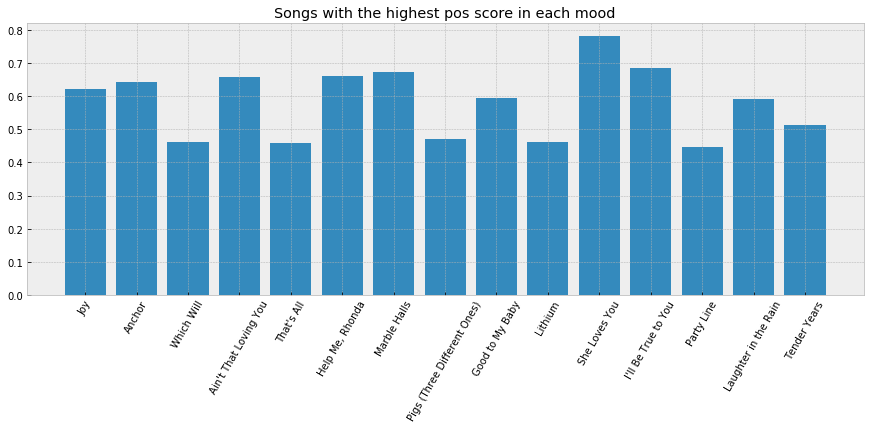

In [8]:
plt.style.use('bmh')
plt.figure(1, figsize=(15, 5))
plt.xticks(rotation=60)
plt.bar(pos_df['pos_title'], pos_df['max_pos_score'])
plt.title('Songs with the highest pos score in each mood')
plt.show()

Overall, the song that receives the highest pos score is "She Loves You" from the mood of fun. The score is 0.73. It also has the highest compound score. Let's see its lyrics, and visualizes its word components.

In [9]:
mps = max(pos_df['max_pos_score'])
mood = pos_df.loc[pos_df['max_pos_score'] == mps, 'moods'].iloc[0]
title = pos_df.loc[pos_df['max_pos_score'] == mps, 'pos_title'].iloc[0]

lyrics = lookUpLyrics(mood, title)

















































Yeah, yeah, yeah, yeah


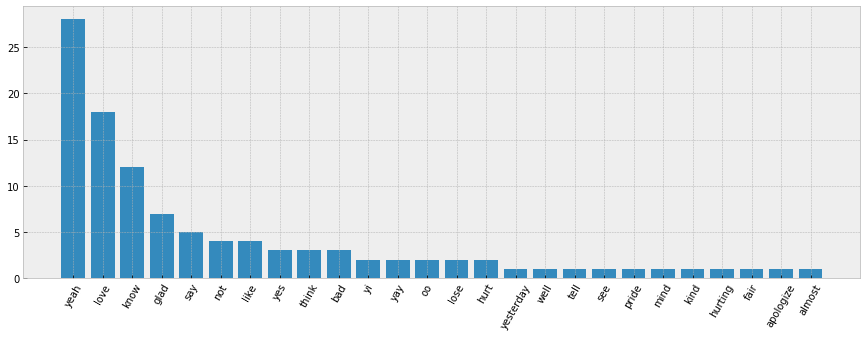

In [12]:
visualizeWordFreq(lyrics)

Do the same analysis for the negative songs. First, compare the songs with the highest neg scores and the songs with the lowest compound score for each mood. Again, some songs with the highest neg score do not the receive the lowest compound score of the mood (sad, bittersweet, etc.).

In [13]:
neg_df = pd.DataFrame([l_moods, l_max_neg, l_min_compound, l_max_neg_title, l_min_compound_title, l_max_neg_artist,
                          l_min_compound_artist], 
                    index = (['moods', 'max_neg_score',  'min_compound_score', 'neg_title', 'min_com_title', 'neg_artist', 
                             'min_com_artist'])).T

neg_df

,moods,max_neg_score,min_compound_score,neg_title,min_com_title,neg_artist,min_com_artist
0,ambitious,0.416,-0.9978,Drunk and Hot Girls,Drunk and Hot Girls,Kanye West,Kanye West
1,angry,0.712,-0.999,We Destroy the Family,The Nigga Ya Love to Hate,Fear,Ice Cube
2,austere,0.398,-0.8893,The Devil,Silence,PJ Harvey,PJ Harvey
3,bittersweet,0.571,-0.998,Before Today,Tragedy,Everything But the Girl,The Bats
4,brassy,0.393,-0.9907,Take Me on the Floor,Take Me on the Floor,The Veronicas,The Veronicas
5,cathartic,0.72,-0.9995,Rape Me,Wrong,Nirvana,Depeche Mode
6,circular,0.457,-0.9889,The French Open,Red Socks Pugie,Foals,Foals
7,earnest,0.584,-0.9979,New Damage,New Damage,Soundgarden,Soundgarden
8,eerie,0.398,-0.9546,The Devil,Hey You,PJ Harvey,Pink Floyd
9,exuberant,0.565,-0.9935,Bad Brain,Bad Brain,Ramones,Ramones


The song with the highest neg score is 'Rape Me', with a score of 0.72. It's compound score is -0.999, which is also the lowest compound score among all the songs.

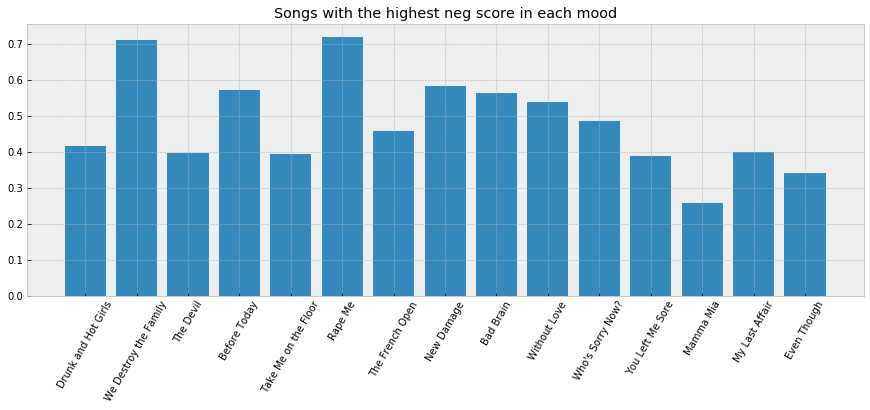

In [14]:
plt.figure(1, figsize=(15, 5))
plt.xticks(rotation=60)
plt.bar(neg_df['neg_title'], neg_df['max_neg_score'])
plt.title('Songs with the highest neg score in each mood')
plt.show()

Let's see its lyrics and its word components.

In [15]:
mns = max(neg_df['max_neg_score'])
mood = neg_df.loc[neg_df['max_neg_score'] == mns, 'moods'].iloc[0]
title = neg_df.loc[neg_df['max_neg_score'] == mns, 'neg_title'].iloc[0]

lyrics = lookUpLyrics(mood, title)





































Rape me


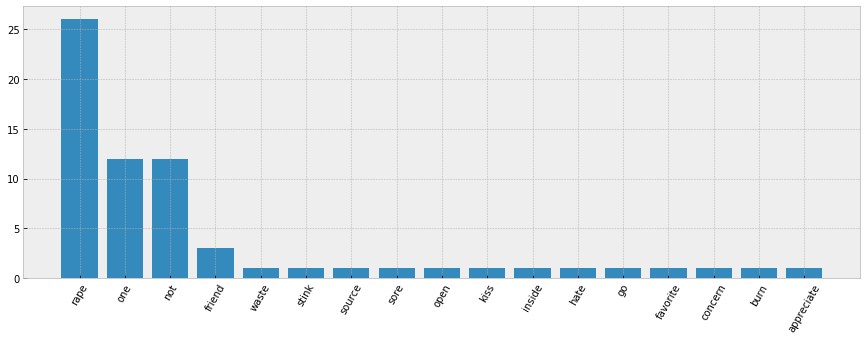

In [16]:
visualizeWordFreq(lyrics)

Now, we will group the songs in our dataset by their genre(s) and visualize the 50 most frequently used words in the lyrics set of a select genre.

In [18]:
dfs_words = {}
words_per_genre_dfs = {}

# Classify lyrics per genre
for i in range(len(dfs)):
    group = dfs[i].groupby('track_genres') # group
    dfs_words[i] = group.apply(lambda x: x['lyrics(normalized_no_stopwords)'].unique())
    dfs_words[i] = dfs_words[i].apply(pd.Series).T
    dfs_words[i] = dfs_words[i].fillna('') # replace NaN with ''

lyrics_per_genre = pd.concat(dfs_words, sort=False)

for genre in lyrics_per_genre:
    lyrics_per_genre[genre] = lyrics_per_genre[genre][lambda x: (~x.duplicated()) | (x.isnull())]
    lyrics_per_genre[genre] = lyrics_per_genre[genre].fillna('')
    data = {}
    data['Word'], data['Frequency'] = np.unique(np.array(
        [word for word in lyrics_per_genre[genre].astype(str).sum().split(" ") # Split to words, get frequency
             if word.isalnum()]), return_counts=True)
    # Store to a new dataframe and sort in descending order
    words_per_genre_dfs[genre] = pd.DataFrame(data=data).sort_values(by=['Frequency'], axis=0, ascending=False, kind='quicksort', 
                                 na_position='last')
         
def visualizeWordFreqPerGenre(genre):
    num_unique_words = len(words_per_genre_dfs[genre]) # Check the number of words
    if num_unique_words > 50: # If gt 50, only display 50
        num_unique_words = 50
    top50_words = words_per_genre_dfs[genre][:num_unique_words]
    
    plt.figure(figsize=(15,10))
    ax = top50_words.plot.bar(x='Word', y='Frequency', rot=70, figsize=(100,50),
                                     fontsize=80, title='Top '+ str(num_unique_words) +' Word Frequencies for Genre: '+ genre
                                                 )
    ax.set_xlabel("Words", fontsize=80)
    ax.set_ylabel("Frequencies", fontsize=80)
    ax.title.set_size(150)
    ax.legend('off')
    
    d = {}
    for a, x in top50_words.values:
        d[a] = x

    wordcloud = WordCloud()
    wordcloud.generate_from_frequencies(frequencies=d)
    plt.figure(figsize=(15,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title('Top '+ str(num_unique_words) +' Word Frequencies for Genre: '+ genre + ' (WordCloud)', fontsize=30)
    plt.show()

<Figure size 1080x720 with 0 Axes>

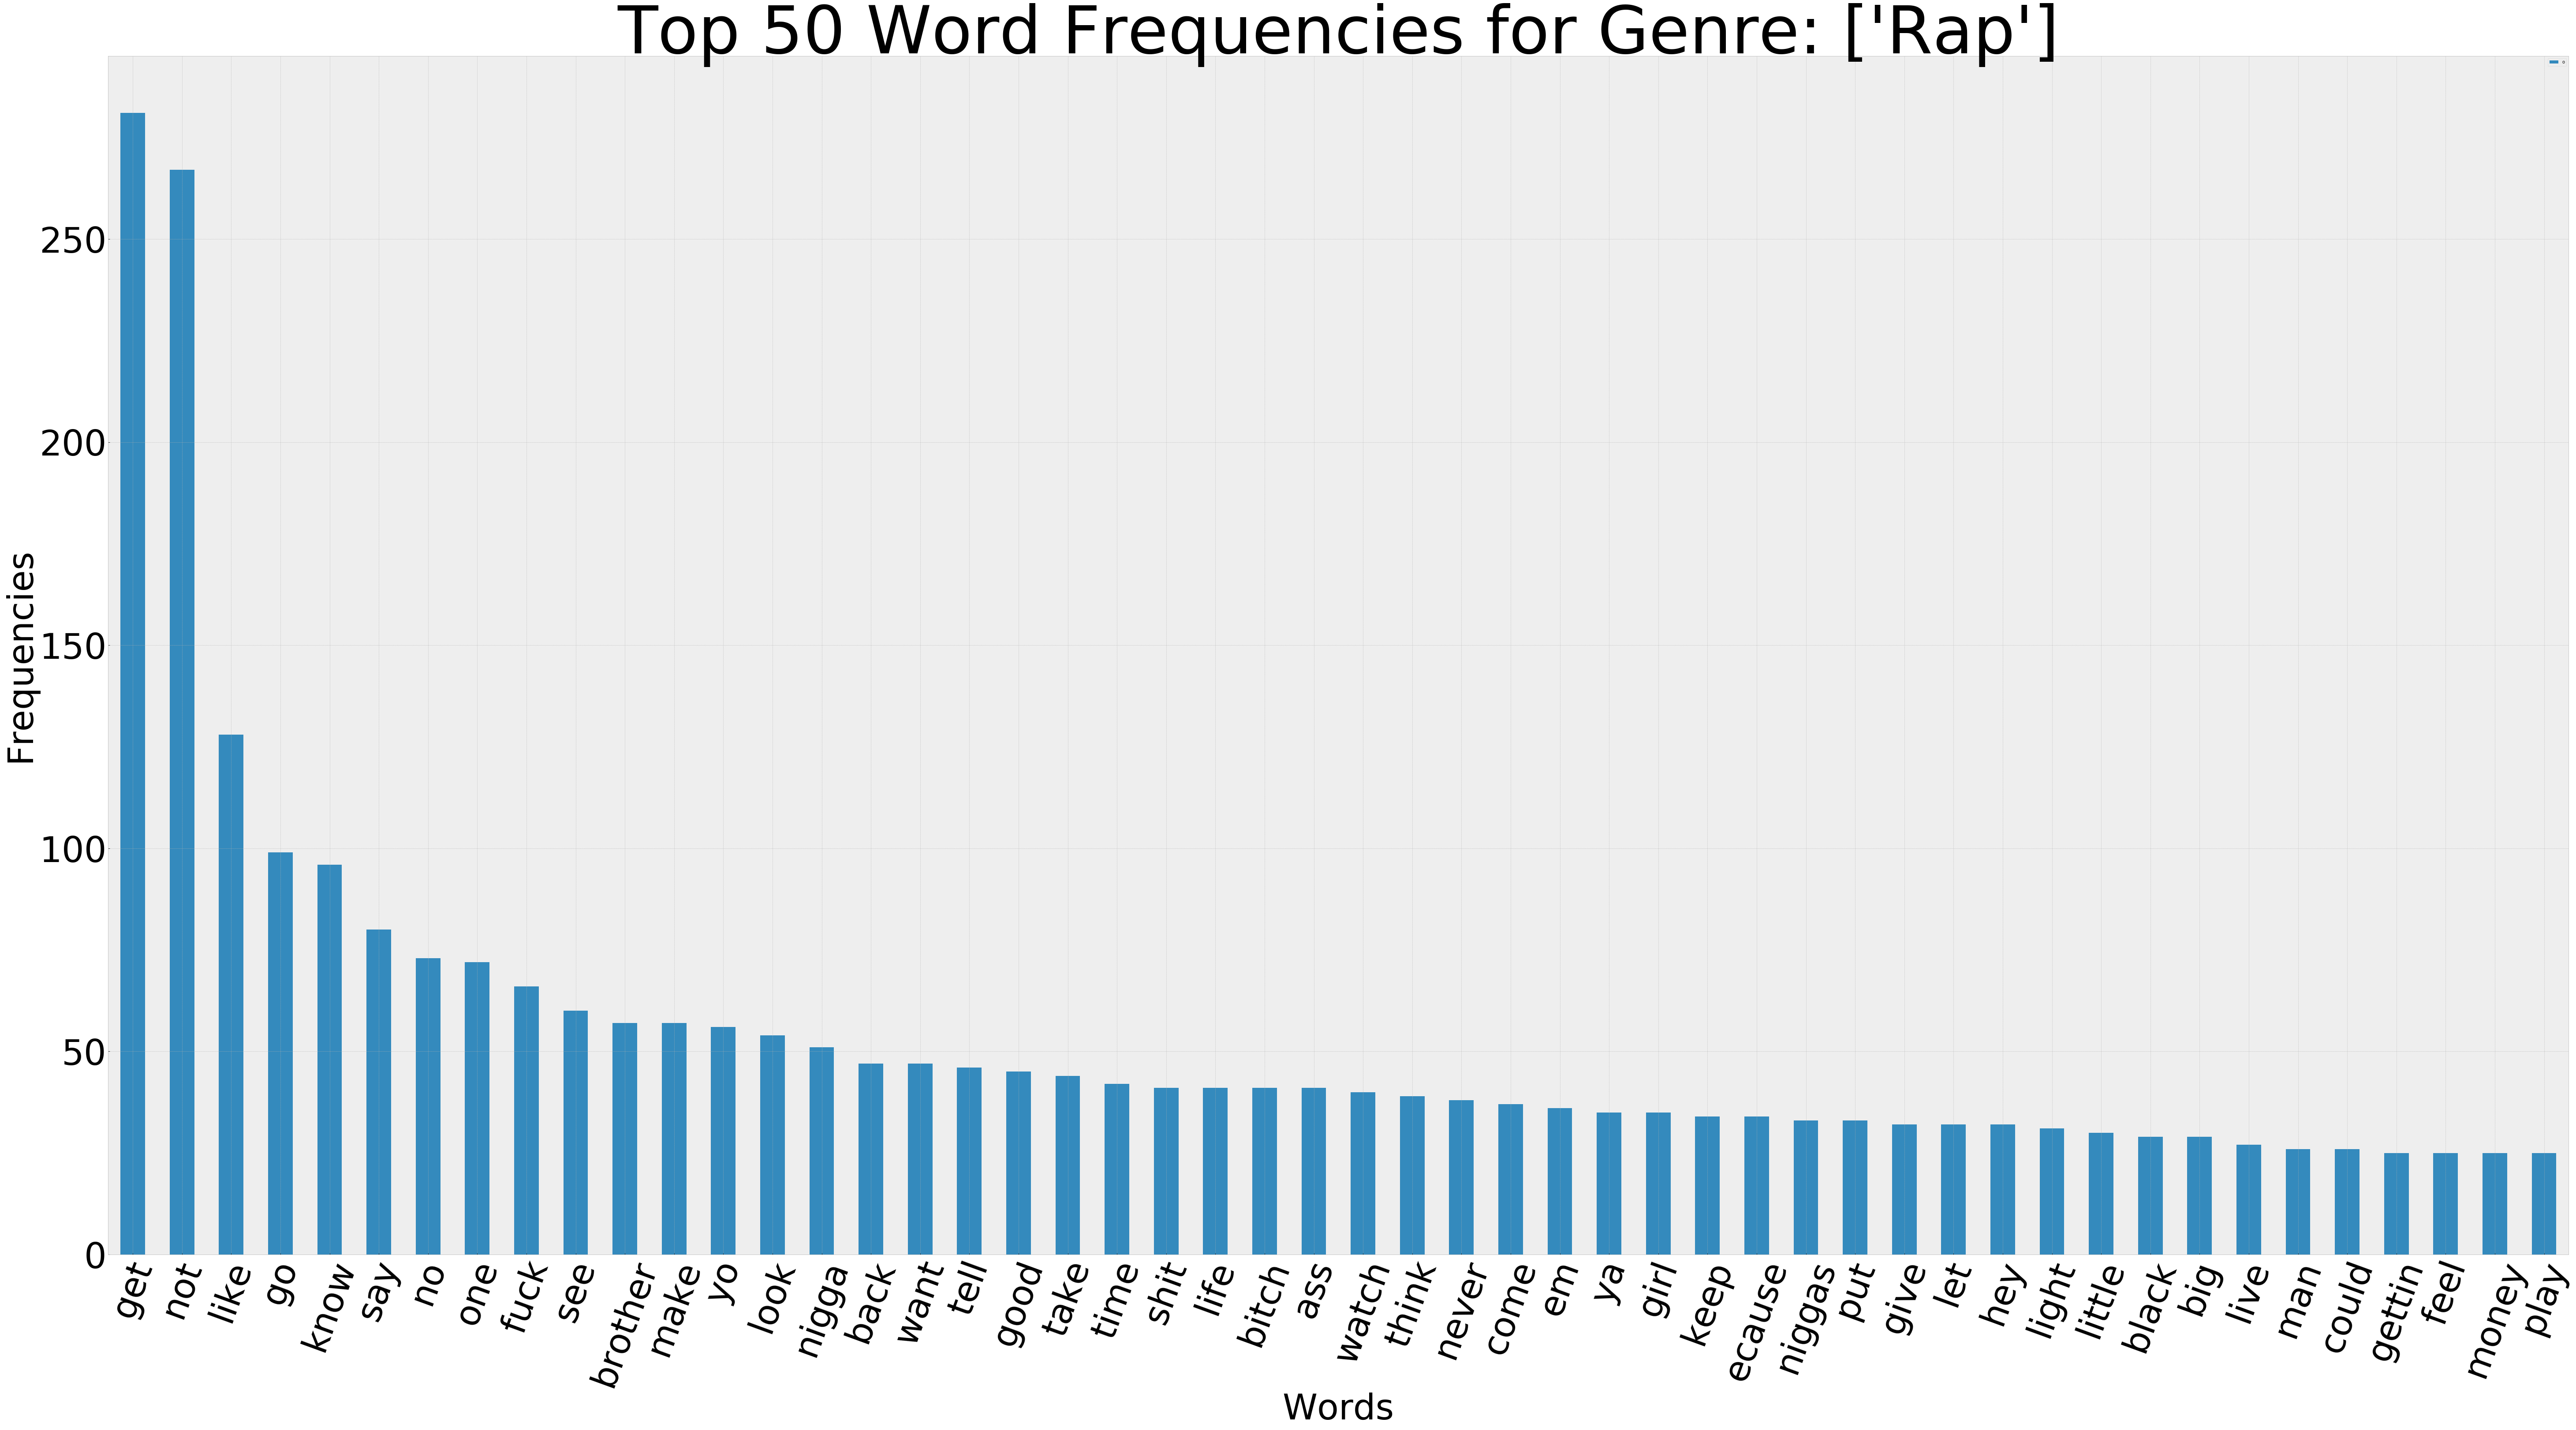

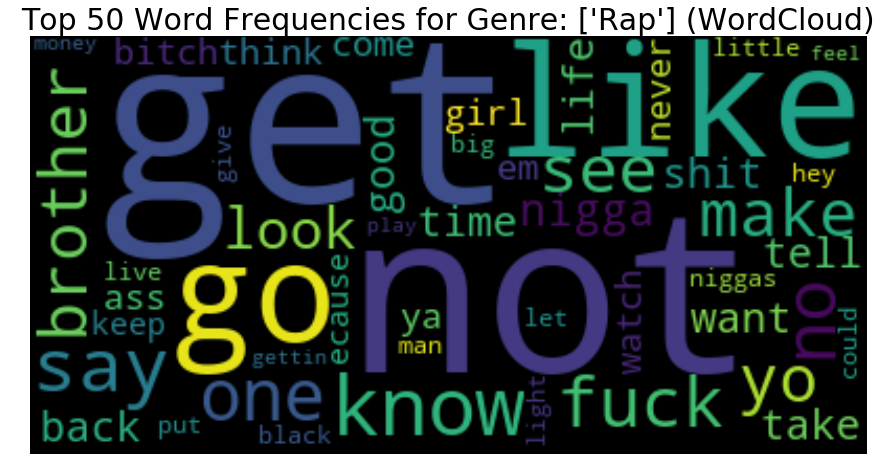

In [19]:
visualizeWordFreqPerGenre("['Rap']") 

Now, using VADER lexicon scoring, we will perform sentiment analysis to each song belonging in a single genre to find the overall sentiment scores of that genre.

In [20]:
# Get the overall sentiment of a genre
def overallSentimentVisualizationPerGenre(genre):
    analyzer = SentimentIntensityAnalyzer()
    l_neg = []
    l_neu = []
    l_pos = []
    l_compound = []

    for lyrics in lyrics_per_genre[genre]:
        if(lyrics):
            vs = analyzer.polarity_scores(lyrics)
            l_neg.append(vs['neg'])
            l_neu.append(vs['neu'])
            l_pos.append(vs['pos'])
            l_compound.append(vs['compound'])
        
    sentimentScores = [l_pos, l_neu, l_neg, l_compound]
        
    # Define styling for each boxplot component
    yellow_diamond = dict(markerfacecolor='y', marker='x')
    medianprops = {'color': 'orange', 'linewidth': 4}
    boxprops = {'color': 'black', 'linestyle': '-'}
    whiskerprops = {'color': 'black', 'linestyle': 'dashed'}
    capprops = {'color': 'black', 'linestyle': '-'}
    meanprops = dict(markerfacecolor='mediumvioletred', markeredgecolor='mediumvioletred', marker='D', markersize=6)
    
    plt.figure(figsize=(15,10))
    box= plt.boxplot(sentimentScores,patch_artist=True,
                     labels=['Positivity','Neutrality','Negativity','Compound'],
                     flierprops=yellow_diamond, medianprops=medianprops, boxprops=boxprops,
                     whiskerprops=whiskerprops, capprops=capprops, meanprops=meanprops,
                     showmeans=True)    
    plt.title('Sentiment Scores using VADER Lexicon for the Lyrics Set in Genre: ' + genre, fontsize=20)
    plt.xlabel('Polarity', fontsize=20)
    plt.ylabel('Score', fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.grid(True)
    
    # Legend
    mean_marker = mlines.Line2D([], [], color='mediumvioletred', marker='D',
                          markersize=6, label='Mean', linewidth=0)
    median_line = mlines.Line2D([], [], color='orange', label='Median', linewidth=4)
    
    # Calculate the mean of the compound score and display result whether the genre is positive, negative, or neutral
    compound_mean_score = np.mean(l_compound)
    result_msg = 'The overall sentiment of the genre: ' + genre + ' is '
    if compound_mean_score >= 0.05: # Positive
        result_msg += 'positive.\nThe mean compound score was %s and is greater than or equal to 0.05.' %round(compound_mean_score, 4)
    elif compound_mean_score <= 0.05: # Negative
        result_msg += 'negative.\nThe mean compound score was %s and is less than or equal to 0.05.' %round(compound_mean_score, 4)
    else: # Neutral
        result_msg += 'neutral.\nThe mean compound score was %s and is between -0.05 and 0.05.' %round(compound_mean_score, 4)

    plt.text(0.1, 0, result_msg, fontsize=20, transform=plt.gcf().transFigure) # add text

    plt.legend(handles=[mean_marker, median_line], loc='center left', bbox_to_anchor=(1, 0.5))
    
    colors = ['mediumseagreen', 'lightgrey', 'salmon', 'steelblue'] # colors for box plots
    
    ## change outline color, fill color and linewidth of the boxes
    for box, c in zip(box['boxes'], colors):
        # change outline color
        box.set( color=c, linewidth=2)
        # change fill color
        box.set(facecolor = c)
    
    plt.show(box)

Let's look at the sentiment scores of the set of lyrics of songs in the genre R&B (Rock and Ballad).

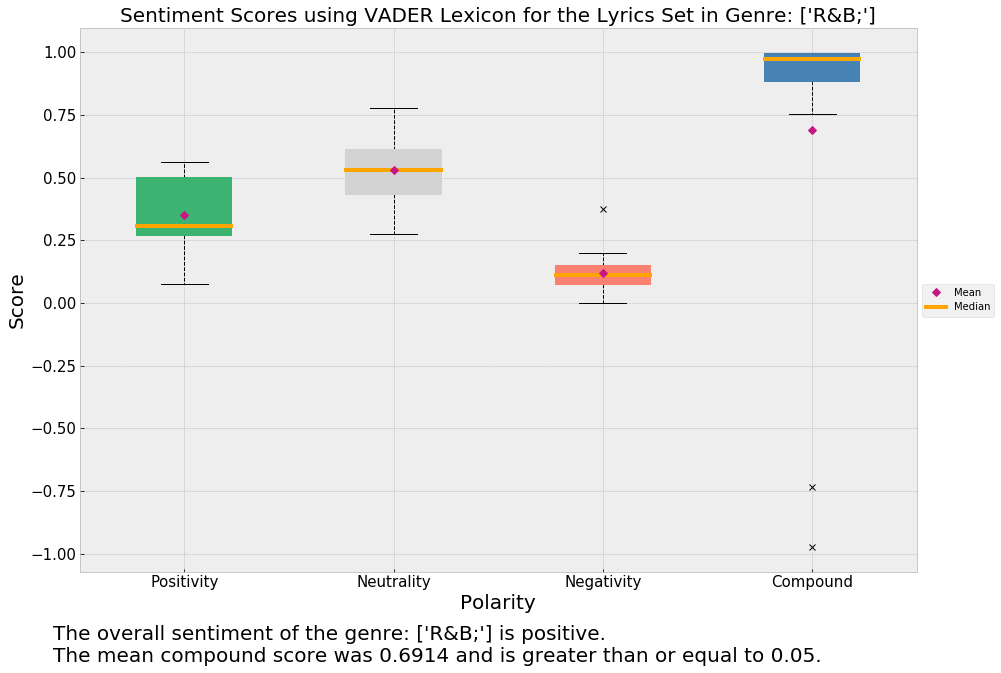

In [21]:
overallSentimentVisualizationPerGenre("['R&B;']")

According to results above, songs in the R&B genre tend to be more positive as its lyrics set scored a mean compound score of greater than 0.05 due to high neutral and positive score means.

Now, lets group the lyrics set of songs by artist(s) and once again perform sentiment analysis to see how their songs vary in sentiment scores throughout their albums over time.

In [23]:
dfs_artist = {}
dfs_track_list = {}
    
# Using the normalized lyrics with no stopwords
for i in range(len(dfs)):
    group = dfs[i].groupby(['album_artist', 'album_title'])
    dfs_artist[i] = group.apply(lambda x: x['lyrics(normalized_no_stopwords)'].unique())
    dfs_artist[i] = dfs_artist[i].apply(pd.Series).T
    dfs_artist[i] = dfs_artist[i].fillna('')
    
    dfs_track_list[i] = group.apply(lambda x: x['track_title'].unique()) 
    dfs_track_list[i] = dfs_track_list[i].apply(pd.Series).T
    dfs_track_list[i] = dfs_track_list[i].fillna('')

# Combine all dataframes from different moods that were grouped by album and artist
artists_albums = pd.concat(dfs_artist, sort=False)
track_titles = pd.concat(dfs_track_list, sort=False)

albums_per_artist_list = [] # list of available (artist, album) tuples in the dataset
number_of_songs_per_album = {} # dict containing number of songs per album

# Concatenate all the lyrics for each album
for artist, album in artists_albums:
    artists_albums[artist, album] = artists_albums[artist, album][lambda x: (~x.duplicated()) | (x.isnull())] # Preserve NaN but get rid of duplicates
    track_titles[artist, album] = track_titles[artist, album][lambda x: (~x.duplicated()) | (x.isnull())] # Preserve NaN but get rid of duplicates
    
    artists_albums[artist, album] = artists_albums[artist, album].fillna('') # change NaN lyrics to ''
    track_titles[artist, album] = track_titles[artist, album].fillna('') # change NaN track titles to ''
    
    number_of_songs_per_album[(artist, album)] = (artists_albums[artist, album] != '').value_counts()[True] # count number of songs per album
    albums_per_artist_list.append((artist, album)) # list albums per artist


In [24]:
# Generate n RGB colors
def generateRGBColorList(NUM_COLORS):
    return sns.color_palette('husl', n_colors=NUM_COLORS)  # a list of RGB tuples

# Visualize the sentiment scores of the artist's songs from different albums
def sentimentPerAlbumsOfArtist(artist):
    albums_score = {}
    albums_list = []
    color_dict = {}
    analyzer = SentimentIntensityAnalyzer()
    colors = generateRGBColorList(len(artists_albums[artist].columns))

    for album, color in zip(artists_albums[artist], colors):
        
        sentimentScores = {}
        sentimentScores['l_neg'] = []
        sentimentScores['l_neu'] = []
        sentimentScores['l_pos'] = []
        sentimentScores['l_compound'] = []
        sentimentScores['l_tracks'] = []
        album_colors = []
        albums_list.append(album)
        
        for lyrics, track_title in zip(artists_albums[artist, album], track_titles[artist, album]):
            if(lyrics): # Ignores all the empty song lyrics ('')
                vs = analyzer.polarity_scores(lyrics)
                sentimentScores['l_tracks'].append(track_title)
                sentimentScores['l_neg'].append(vs['neg'])
                sentimentScores['l_neu'].append(vs['neu'])
                sentimentScores['l_pos'].append(vs['pos'])
                sentimentScores['l_compound'].append(vs['compound'])
                album_colors.append(color)
                
        albums_score[(artist, album)] = sentimentScores
        color_dict[(artist, album)] = album_colors
    
    positivity = [] # overall positivity of the artist 
    negativity = [] # overall negativity of the artist 
    neutralness = [] # overall neutrality of the artist 
    compound = [] # overall compound of the artist 
    tracks = [] # tracks of the artist 
    colors = [] # color of each track to determine which album they are from 
    
    for album in albums_list:
        positivity.append(albums_score[(artist, album)]['l_pos'])
        negativity.append(albums_score[(artist, album)]['l_neg'])
        neutralness.append(albums_score[(artist, album)]['l_neu'])
        compound.append(albums_score[(artist, album)]['l_compound'])
        tracks.append(albums_score[(artist, album)]['l_tracks'])
        colors.append(color_dict[(artist, album)])
    
    plt.figure(figsize=(20,10))
    
    plt.title('Sentiment Scores using VADER Lexicon for the Lyrics Set of the Artist(s): ' + artist, fontsize=20)
    
    # Legend
    
    positive_line = mlines.Line2D([], [], c=(0, 1, 0), label='Positivity', linewidth=5)
    negative_line = mlines.Line2D([], [], c=(1, 0, 0), label='Negativity', linewidth=5)
    neutral_line = mlines.Line2D([], [], c=(0.5, 0.5, 0.5), label='Neutrality', linewidth=5)
    compound_line = mlines.Line2D([], [], c=(0, 0, 1), label='Compound', linewidth=5)

    
    plt.legend(handles=[positive_line, negative_line, neutral_line, compound_line], loc='center left', bbox_to_anchor=(1, 0.5))
    
    positivity = [(x, y) for x, y in zip(np.concatenate(tracks), np.concatenate(positivity))]
    positivity = sorted(set(positivity), key=positivity.index)
    
    plt.plot(*zip(*positivity), '-o', c=(0, 1, 0))
    
    negativity = [(x, y) for x, y in zip(np.concatenate(tracks), np.concatenate(negativity))]
    negativity = sorted(set(negativity), key=negativity.index)
    
    plt.plot(*zip(*negativity), '-o', c=(1, 0, 0))
        
    neutralness = [(x, y) for x, y in zip(np.concatenate(tracks), np.concatenate(neutralness))]
    neutralness = sorted(set(neutralness), key=neutralness.index)
    
    plt.plot(*zip(*neutralness), '-o', c=(0.5, 0.5, 0.5))
    
    plt.xticks(rotation=90, fontsize=12)
    plt.yticks(fontsize=12)

    for xtick, c in zip(plt.gca().get_xticklabels(), [tuple(x) for x in np.concatenate(colors)]):
        xtick.set_color(c)
        
    plt.xlabel("Songs (grouped per album by colors)", fontsize=20)
    plt.ylabel("Score", fontsize=20)
    
        
    compound = [(x, y) for x, y in zip(np.concatenate(tracks), np.concatenate(compound))]
    compound = sorted(set(compound), key=compound.index)
    
    plt.plot(*zip(*compound), '-o', c=(0, 0, 1))
        
    plt.show()

Lets observe the sentiment scores of the songs of an artist named Billie Holiday and see how it changes throughout her albums.

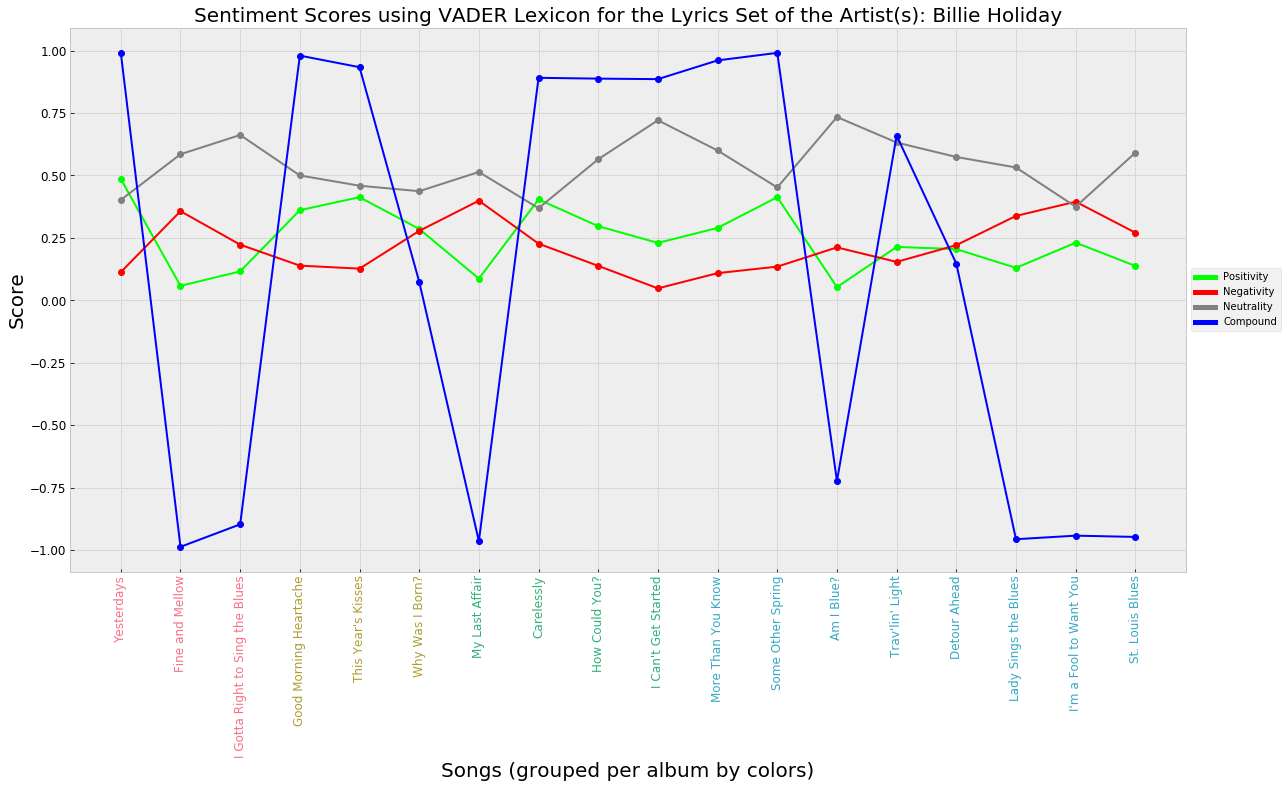

In [25]:
sentimentPerAlbumsOfArtist('Billie Holiday')

Based the results, in terms of sentiment scores,  it seems that most of her songs are either extremely positive, or extremely negative, as most compound scores are either close to 1 or -1.